# 1. Labeling Function:
**For your analysis, you may focus on a subset of the 54 classes provided.**

In [1]:
import os 
import math
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from collections import Counter
from sklearn.manifold import  TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

**DATA LOADING**

In [2]:
PATH_TO_DATASET = '../MLPC2025_classification'
METADATA_CSV = os.path.join(PATH_TO_DATASET, "metadata.csv")
ANNOTATIONS_CSV = os.path.join(PATH_TO_DATASET, "annotations.csv")
AUDIO_FEATURE_FOLDER = os.path.join(PATH_TO_DATASET, "audio_features")
AUDIO_FOLDER = os.path.join(PATH_TO_DATASET, "audio")

In [3]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

an_df = pd.read_csv("annotations.csv")
meta_df = pd.read_csv("metadata.csv")

### (a) Assess how accurately the applied labeling functions capture the intended classes.

**LABEL CLEANING**

In [4]:
an_df["labels"] = an_df["categories"].str.lower().str.replace(r"[\'\[\]]", "", regex=True).str.strip()

print("=== Cleaned Labels ===")
for i in range(3):
    print(f"Original: {an_df['categories'].iloc[i]:<30} → Cleaned: {an_df['labels'].iloc[i]}")

=== Cleaned Labels ===
Original: ['Alarm']                      → Cleaned: alarm
Original: ['Alarm']                      → Cleaned: alarm
Original: ['Alarm', 'Beep/Bleep']        → Cleaned: alarm, beep/bleep


Why did we do this? 
- Standardizes labels (['Alarm', 'Beep/Bleep'] → alarm, beep/bleep) for consistency.
- Ensures/enables fair comparison between free-text annotations and target classes.

**LABEL DISTRIBUTION**

In [5]:
top_labels = an_df["labels"].value_counts() 
for label, count in top_labels.items():
    pct = (count / len(an_df)) * 100
    print(f"{label:<15} {count:>5} ({pct:.1f}%)")

bird chirp       2437 (8.8%)
speech           2284 (8.3%)
dog bark         1374 (5.0%)
wind              860 (3.1%)
insect buzz       816 (3.0%)
car               816 (3.0%)
bell              771 (2.8%)
footsteps         723 (2.6%)
drums             662 (2.4%)
guitar            639 (2.3%)
beep/bleep        637 (2.3%)
rain              619 (2.2%)
waves             619 (2.2%)
laughter          529 (1.9%)
cat meow          519 (1.9%)
drip              485 (1.8%)
shout             473 (1.7%)
hammer            465 (1.7%)
snoring           438 (1.6%)
piano             431 (1.6%)
power drill       422 (1.5%)
clapping          416 (1.5%)
stream/river      411 (1.5%)
sheep/goat bleat   391 (1.4%)
crying            387 (1.4%)
thunder           371 (1.3%)
horn honk         362 (1.3%)
train             355 (1.3%)
airplane          341 (1.2%)
fire              332 (1.2%)
siren             328 (1.2%)
motorcycle        302 (1.1%)
singing           301 (1.1%)
bird chirp, singing   263 (1.0%)
chainsaw 

Why did we do this? 
- identifies most frequent labels
- highlights potential class imbalances

#### Do the mapped classes correspond well to the free-text annotations?

In [6]:
import re
from collections import defaultdict, Counter
from nltk.stem import WordNetLemmatizer
import nltk
from sound_config import sound_mapping, context_words, label_to_category

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Tracking dictionaries for used terms
used_sound_mappings = defaultdict(set)
used_context_words = defaultdict(set)
useful_context_words = defaultdict(Counter)

label_to_category = {
    **{cat.lower(): cat for cat in categories}  # Generic lowercase mapping
}

def standardize_label(label):
    return label_to_category.get(label.lower(), label)

def lemmatize(text):
    words = re.findall(r'\b[\w/]+\b', text.lower())
    processed = set()
    for word in words:
        variants = [
            lemmatizer.lemmatize(word, pos='v'),
            lemmatizer.lemmatize(word),
            word.rstrip('ingsed')
        ]
        if any(c in word for c in [' ', '/', '-']):
            variants.extend(lemmatizer.lemmatize(part) for part in re.split(r'[\s/-]', word))
        processed.update(variants)
    return processed

def check_context(text_words, label):
    std_label = standardize_label(label)
    base_label = std_label.split()[0].lower()
    context_list = context_words.get(std_label, [])
    matches = 0
    
    for word in context_list:
        lemma_word = lemmatizer.lemmatize(word)
        if lemma_word in text_words:
            matches += 1
            used_context_words[std_label].add(word)
            useful_context_words[std_label][word] += 1
    
    min_matches = 2 if len(context_list) > 3 else 1
    return matches >= min_matches or base_label in text_words

def is_match(text, label):
    words = lemmatize(text)
    std_label = standardize_label(label)
    label_parts = re.split(r'[\s/]', std_label)
    
    # Check label parts
    if any(lemmatizer.lemmatize(part.lower()) in words for part in label_parts):
        return True

    # Check sound mappings
    for variant in sound_mapping.get(std_label, []):
        variant_words = variant.split()
        if any(lemmatizer.lemmatize(word) in words for word in variant_words):
            used_sound_mappings[std_label].add(variant)
            return True

    return check_context(words, std_label)

def summarize_matches(df):
    stats = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})

    for _, row in df.iterrows():
        text = row['text'].lower()
        labels = [l.strip() for raw in row['labels'].split(',') for l in raw.strip().split('/')]
        matched = [l for l in labels if is_match(text, l)]

        if matched:
            stats['_overall']['matched'] += 1
            for m in matched:
                stats[m]['matched'] += 1
                if len(stats[m]['examples']) < 3:
                    stats[m]['examples'].append(text[:100] + '...')

        for l in labels:
            stats[l]['total'] += 1

    print(f"\nMatch Summary ({len(df)} samples):")
    print(f"Overall matches: {stats['_overall']['matched']} ({stats['_overall']['matched']/len(df):.1%})")

    # Standardize labels for accuracy summary
    summary = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})
    for raw, data in stats.items():
        if raw == '_overall':
            continue
        std = standardize_label(raw)
        summary[std]['matched'] += data['matched']
        summary[std]['total'] += data['total']
        summary[std]['examples'].extend(data['examples'])

    print("\nAccuracy Summary (Ranked by Accuracy):")
    print("{:<25} {:<10} {:<10} {:<10}".format("Category", "Matched", "Total", "Accuracy"))
    print("-" * 55)
    
    # Create sorted list by accuracy (descending) then by matched count (descending)
    sorted_categories = sorted(
        [(cat, data) for cat, data in summary.items() if cat in categories],
        key=lambda x: (
            x[1]['matched'] / x[1]['total'] if x[1]['total'] > 0 else 0,  # Accuracy
            x[1]['matched']  # Then by matched count
        ),
        reverse=True
    )
    
    for cat, data in sorted_categories:
        acc = data['matched'] / data['total'] if data['total'] else 0
        print(f"{cat:<25} {data['matched']:<10} {data['total']:<10} {acc:.1%}")

# -------------------------------
# MAIN PROCESSING
# -------------------------------
summarize_matches(an_df)

# -------------------------------
# OPTIONAL ANALYSIS (run separately after processing)
# -------------------------------
def analyze_used_terms():
    """Analyze which config terms were actually used in matching"""
    print("\nConfiguration Terms Analysis:")
    
    # Sound mapping usage
    print("\nSound Mapping Usage:")
    for category, terms in sound_mapping.items():
        used = used_sound_mappings.get(category, set())
        unused = set(terms) - used
        print(f"\n{category}:")
        print(f"Used ({len(used)}/{len(terms)}): {', '.join(used) if used else 'None'}")
        print(f"Unused: {', '.join(unused) if unused else 'None'}")

    # Context words usage
    print("\nContext Words Usage:")
    for category, words in context_words.items():
        used = used_context_words.get(category, set())
        unused = set(words) - used
        print(f"\n{category}:")
        print(f"Used ({len(used)}/{len(words)}): {', '.join(used) if used else 'None'}")
        print(f"Unused: {', '.join(unused) if unused else 'None'}")

def get_optimized_configs():
    """Return optimized configs containing only used terms"""
    optimized_sound = {
        cat: sorted(used_sound_mappings.get(cat, set())) 
        for cat in sound_mapping
    }
    
    optimized_context = {
        cat: sorted(used_context_words.get(cat, set())) 
        for cat in context_words
    }
    
    return optimized_sound, optimized_context

# To see which terms were used (run after summarize_matches):
#analyze_used_terms()

# To get optimized configs (run after summarize_matches):
used_sound, used_context = get_optimized_configs()

[nltk_data] Downloading package wordnet to C:\Users\jeron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Match Summary (27552 samples):
Overall matches: 25270 (91.7%)

Accuracy Summary (Ranked by Accuracy):
Category                  Matched    Total      Accuracy  
-------------------------------------------------------
Cat Meow                  540        541        99.8%
Dog Bark                  1439       1446       99.5%
Cow Moo                   189        190        99.5%
Alarm                     353        355        99.4%
Pig Oink                  139        140        99.3%
Snoring                   470        474        99.2%
Cough                     220        222        99.1%
Doorbell                  87         88         98.9%
Sewing Machine            81         82         98.8%
Siren                     388        393        98.7%
Rooster Crow              147        149        98.7%
Horn Honk                 719        730        98.5%
Bird Chirp                2897       2956       98.0%
Sneeze                    38         39         97.4%
Train                     

**Components:**
- sound_mapping: Handles synonyms (e.g., "woof" → "dog bark").
- context_words: Checks related terms (e.g., "barking" → "dog bark").

**Output:** summarize_matches() prints accuracy per class (e.g., Cat Meow: 99.8%).

**Insight:** 
- High accuracy → Labels are reliable 
- Low accuracy → Review mappings; Mismatching for  ambiguous cases (e.g., "truck" vs. "car" confusion).

**OPTIMIZATION**

In [7]:
import json

# Save to JSON files
with open('optimized_sound_mapping.json', 'w') as f:
    json.dump(used_sound, f, indent=2)

with open('optimized_context_words.json', 'w') as f:
    json.dump(used_context, f, indent=2)

Why? 
- Identifies which mapping terms were actually used (e.g., "woof" used, "ruff" unused).

**Action:** Save optimized mappings to JSON for future use.

#### Are the labeled events clearly audible within the indicated time regions?

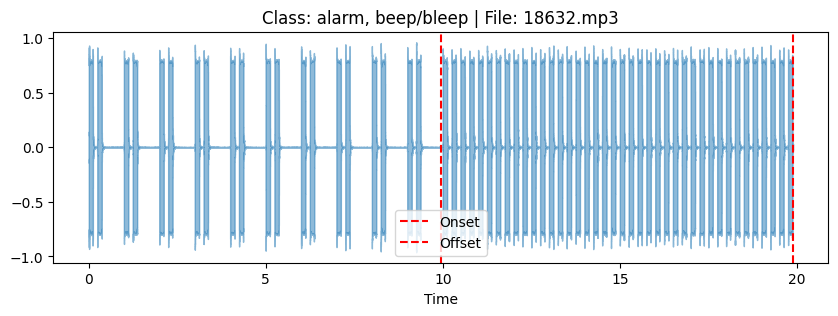

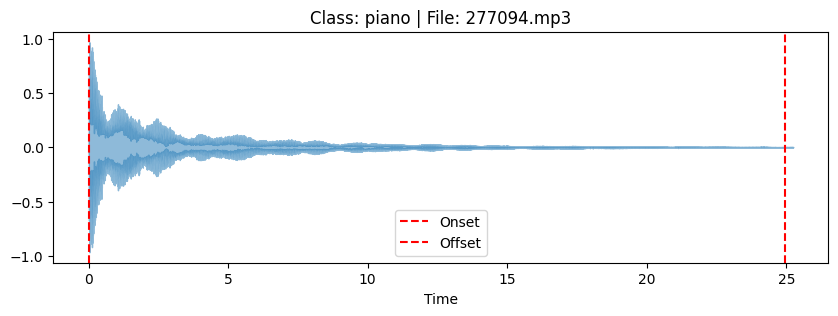

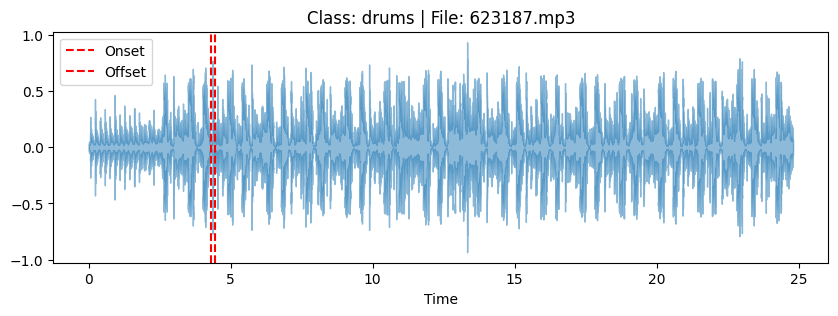

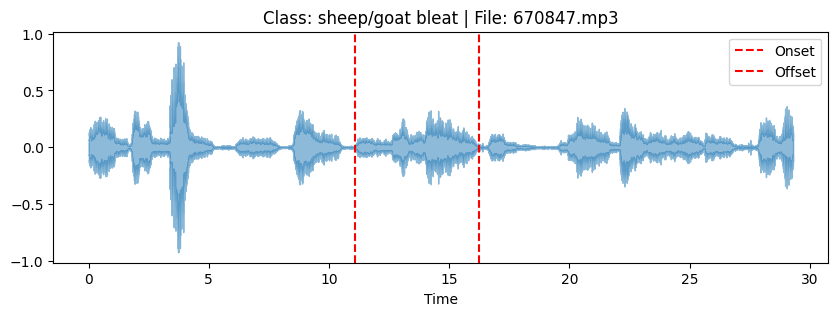

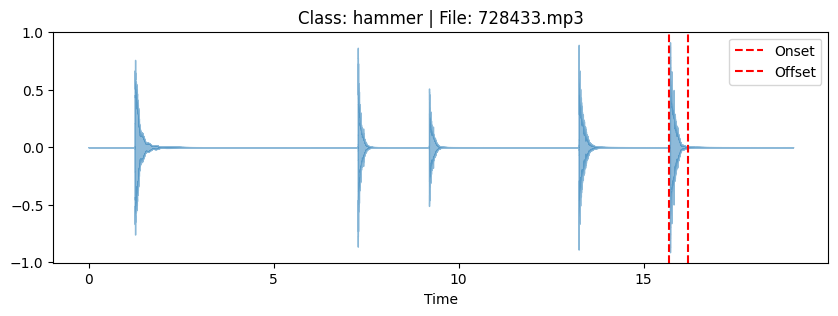

In [8]:
import librosa.display

def plot_annotation_audio(filename, onset, offset, class_label):
    """Plot waveform + labeled region for audibility check."""
    y, sr = librosa.load(os.path.join(AUDIO_FOLDER, filename))
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.axvline(onset, color='r', linestyle='--', label='Onset')
    plt.axvline(offset, color='r', linestyle='--', label='Offset')
    plt.title(f"Class: {class_label} | File: {filename}")
    plt.legend()
    plt.show()

# Example: Check 5 random annotations
for _, row in an_df.sample(5).iterrows():
    plot_annotation_audio(row['filename'], row['onset'], row['offset'], row['labels'])

**Output:** Waveform plots with labeled regions (onset/offset).

**Example:** A "dog bark" label should align with a sharp audio peak.

**Insight:** Visual confirmation ensures temporal accuracy.

### (b) Which audio features appear most useful for distinguishing between the classes of interest? 

*Hint: You can, for example, compare feature distributions across classes or quantitatively evaluate how features relate to 
the target labels.*

**FEATURE LOADING AND PREPROCESSING**

In [9]:
feature_names= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2","flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]

In [10]:
features = {name: [] for name in feature_names}
for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Loading features"):
    file_name = f"{row['filename']}".replace('.mp3', '.npz')
    path = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
    data = np.load(path)
    for name in feature_names:
        features[name].append(data[name])

Loading features: 100%|██████████| 8230/8230 [01:02<00:00, 131.64it/s]


Why? 
- Loads all audio features for analysis.

**Output:** features dictionary containing raw feature arrays.

**FEATURE VARIANCE ANALYSIS**

In [25]:
feature_variance = {}
for name, feat_list in features.items():
    all_data = np.concatenate(feat_list, axis=0)
    feature_variance[name] = np.mean(np.var(all_data, axis=0))

var_df = pd.DataFrame.from_dict(feature_variance, orient='index', columns=['Variance'])
var_df.style\
  .format('{:.4f}')\
  .background_gradient(cmap='Blues')\
  .set_caption('Feature Variance Ranking')

,Variance
embeddings,0.1644
melspectrogram,4.0165
mfcc,7.9593
mfcc_delta,0.0374
mfcc_delta2,0.0117
flatness,0.0082
centroid,890953.9930
bandwidth,541192.7031
flux,231.3250
contrast,21.7124


Why? 
- High variance = Feature changes significantly across samples → More discriminative.

**Key Insight:**
- power (highest variance) → Likely useful.
- flatness (lowest variance) → Less useful.

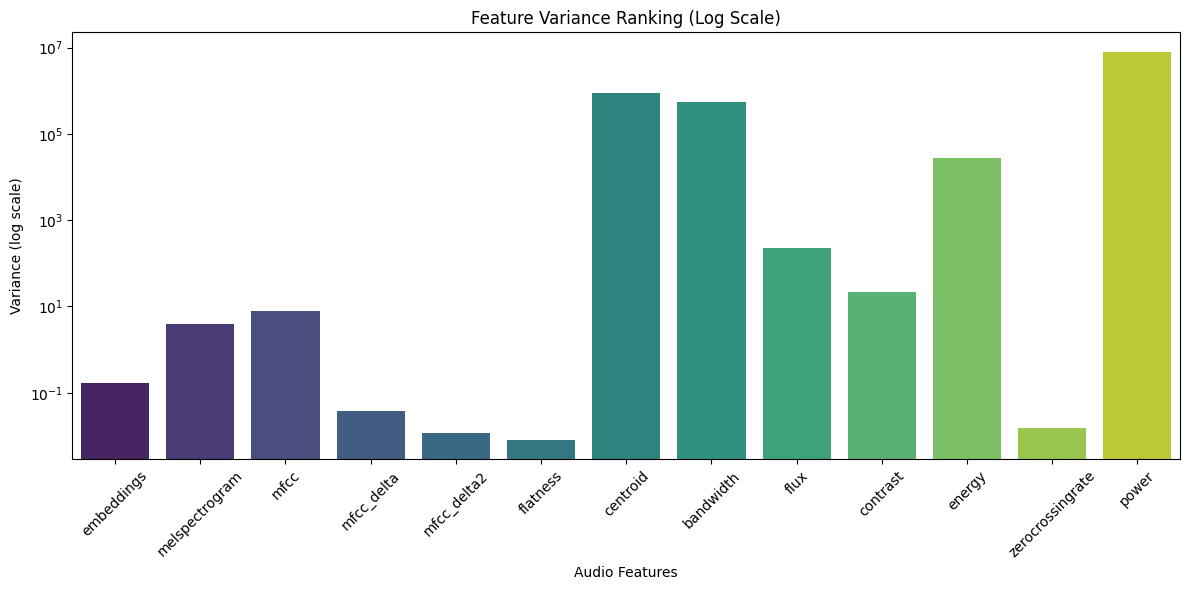

In [12]:
plt.figure(figsize=(12,6))

plot_df = var_df.reset_index().rename(columns={'index': 'Feature', 0: 'Variance'})

sns.barplot(data=plot_df, 
            x='Feature',
            y='Variance',
            hue='Feature',
            legend=False,
            palette='viridis')

# Formatting
plt.title("Feature Variance Ranking (Log Scale)")
plt.xticks(rotation=45)
plt.yscale('log')  # Important for visualizing wide-ranging values
plt.xlabel('Audio Features')
plt.ylabel('Variance (log scale)')
plt.tight_layout()
plt.show()

**Observation:** power, centroid, and bandwidth dominate. Precisely, power>centroid>bandwidth.

**FEATURE CORRELATION ANALYSIS**

In [13]:
# Create aggregated version (mean of MFCCs)
def summarize_feature(feature_list, agg_func=np.mean):
    """
    Reduce each sample's feature values to a single summary statistic.
    Handles both arrays (MFCCs) and single values (power).
    """    
    return [agg_func(sample) if isinstance(sample, (np.ndarray, list)) else sample
            for sample in feature_list]

In [14]:
summary_dict = {}
for name, values in features.items():
    summary_dict[name] = summarize_feature(values)
df_summary = pd.DataFrame(summary_dict)

**Purpose:** Condenses each audio sample's features into a single value (mean by default).

Example: A sample's 13 MFCC coefficients → averaged to 1 value per sample.

In [15]:
corr_matrix = df_summary.corr()

**Output:** A correlation matrix showing how pairwise features move together (range: -1 to 1).

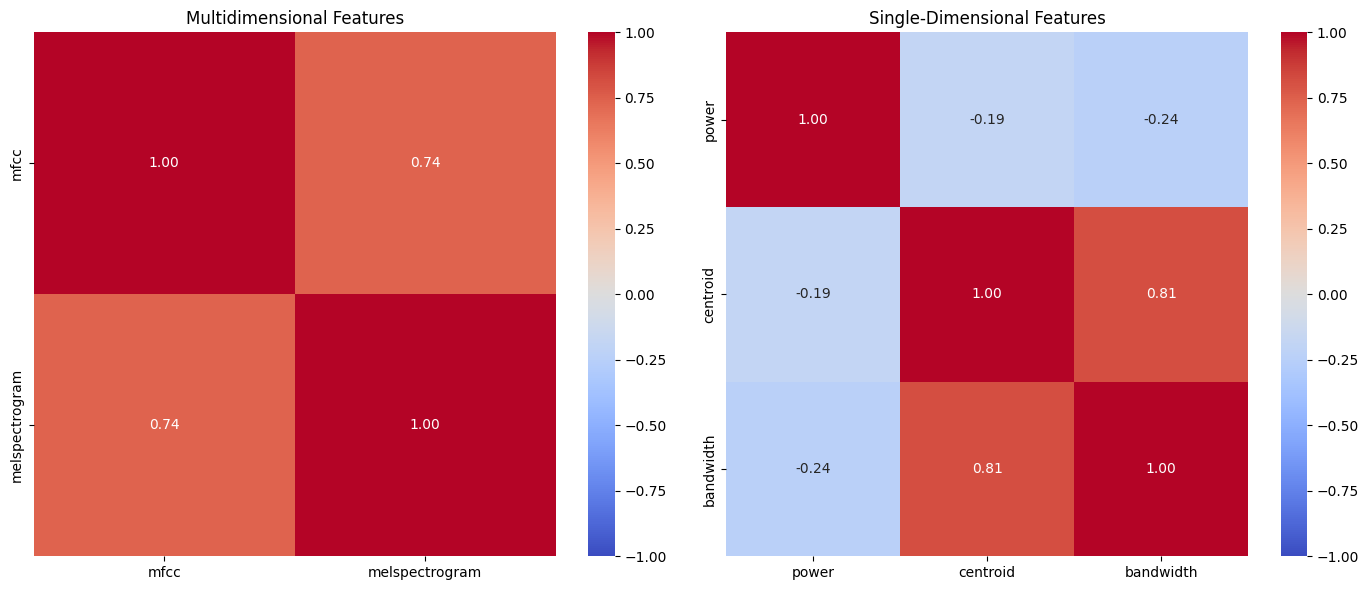

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(
    corr_matrix.loc[['mfcc', 'melspectrogram'], ['mfcc', 'melspectrogram']],
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    ax=ax[0] 
)
sns.heatmap(
    corr_matrix.loc[['power', 'centroid', 'bandwidth'], ['power', 'centroid', 'bandwidth']], 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    ax=ax[1]
)    
ax[0].set_title('Multidimensional Features')
ax[1].set_title('Single-Dimensional Features')
plt.tight_layout()
plt.show()            

#### Multidimensional Features - MFCC vs. Melspectrogram (Correlation = 0.74):
**Observation:**
Moderately high correlation (0.74) between melspectrograms and MFCCs, suggesting both capture similar spectral characteristics. However, the melspectrograms yielded stronger Mutual Information (MI) scores, indicating greater discriminative power in this context.

**Why?**

Both are spectral features derived from similar transforms, but:

- **Melspectrograms** retain detailed spectral energy patterns across the mel scale, offering richer representations of timbral texture.
- **MFCCs** compress this information to emphasize perceptual relevance but may lose subtle distinctions critical for fine-grained classification.

**Conclusion:**
- Keep **melspectrograms** (higher MI scores, more detailed)
- Drop **MFCCs** (lower MI scores, more abstracted, potentially redundant)

#### Single-Dimensional Features (Power, Centroid, Bandwidth) Analysis:
**1. Power vs. Others**

- **Power vs. Centroid (-0.19):** Near-zero → Loudness and spectral "brightness" are independent.

- **Power vs. Bandwidth (-0.24):** Minimal correlation → Loudness and frequency spread measure different things.

**Conclusion:** 
- Keep power (unique loudness metric)

**2. Centroid vs. Bandwidth (0.81)**

**Problem:**

Very high correlation (0.81) → Both describe spectral shape:

- *Centroid:* Where energy concentrates (low vs. high frequencies)
- *Bandwidth:* How spread out the energy is

**Conclusion:**
- Keep centroid (more interpretable)
- Drop bandwidth (avoids multicollinearity without losing critical info)

*Exception:* Keep both if bandwidth is theoretically important for your specific sounds (e.g., distinguishing "hiss" vs. "rumble").

##### Final reasoning why are we keeping the selected featres:
**Melspectrogram:** Provides a detailed spectral representation with stronger discriminative power (higher MI scores); MFCCs are more compressed and redundant.

**Power** (unique loudness information) and **centroid** (best spectral shape descriptor; **bandwidth** is redundant -> highly correlated with centroid (0.81)) show high variance and low correlation, capturing independent aspects of the audio signal. These features are non-redundant and should both be retained to maximize information diversity.

**CLASS SEPARATION ANALYSIS**

In [17]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

def analyze_feature_types(class1, class2, show_plot=True):
    """Analyze using aggregated features (mean MFCCs)
    
    Args:
        class1, class2: Classes to compare
        show_distributions: Whether to plot feature distributions
    """
    # Filter and merge data
    filtered_labels = an_df[an_df["labels"].isin([class1, class2])].copy()
    merged_df = filtered_labels.merge(df_summary, left_index=True, right_index=True)
    X = merged_df[df_summary.columns]
    y = merged_df["labels"]
    
    # Compute MI scores (original scaling)
    mi_scores = mutual_info_classif(X, y, random_state=42)
    
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)

    if show_plot:
        # Plot importance with original scaling
        plt.figure(figsize=(10, 5))
        ax = sns.barplot(
            data=mi_df, 
            x='MI_Score', 
            y='Feature', 
            hue='Feature',
            dodge=False, 
            palette='viridis', 
            legend=False
        )
        
        # Set x-axis limit based on your typical score range
        plt.xlim(0, 0.05)  # Adjusted to match your output range
        
        plt.title(f"Feature Importance (Aggregated)\n{class1} vs {class2}")
        plt.xlabel("Mutual Information Score")
        plt.axvline(0.02, color='red', linestyle='--', alpha=0.5)  # Reference line
        
        # Add value annotations
        for p in ax.patches:
            width = p.get_width()
            if width > 0.005:  # Only label significant scores
                ax.text(width + 0.002, p.get_y() + p.get_height()/2,
                    f'{width:.4f}', ha='left', va='center')
        
        plt.tight_layout()
        plt.show()
    
    return mi_df

In [18]:
from sklearn.preprocessing import LabelEncoder

def analyze_mfcc_components(class1, class2):
    """Analyze all MFCC coefficients (32 or 13) with simplified code"""
    # 1. Extract and average MFCCs over time
    mfcc_means = [np.mean(mfcc, axis=0) for mfcc in features["mfcc"] 
                 if isinstance(mfcc, np.ndarray) and mfcc.ndim == 2]
    
    if not mfcc_means:
        raise ValueError("No valid MFCC arrays found. Check your feature shapes.")
    
    # 2. Create feature matrix and filter classes
    mfcc_data = np.array(mfcc_means)
    n_coeffs = mfcc_data.shape[1]  # Will be 13 or 32
    
    # Get corresponding labels (assuming same length)
    y = an_df["labels"].iloc[:len(mfcc_data)]  
    mask = y.isin([class1, class2])
    
    # 3. Compute MI scores
    mi_scores = mutual_info_classif(mfcc_data[mask], 
                                   LabelEncoder().fit_transform(y[mask]),
                                   discrete_features=False)
    
    # 4. Create and plot results
    mfcc_df = pd.DataFrame({
        "Coefficient": [f"MFCC_{i}" for i in range(n_coeffs)],
        "MI_Score": mi_scores
    }).sort_values("MI_Score", ascending=False)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(  # Assign the plot to 'ax' for annotations
        data=mfcc_df.head(20), 
        x="MI_Score", 
        y="Coefficient", 
        hue="Coefficient",  # Explicitly assign hue
        dodge=False, 
        palette='viridis', 
        legend=False
    )
    
    # Add value annotations
    for p in ax.patches:
        width = p.get_width()
        if width > 0.005:  # Only label significant scores
            ax.text(width + 0.002, p.get_y() + p.get_height()/2,
                   f'{width:.4f}', ha='left', va='center')
    
    plt.xlim(0, 0.05)
    plt.title(f"Top MFCC Coefficients: {class1} vs {class2}\n(Found {n_coeffs} coefficients)")
    plt.axvline(0.02, color='red', linestyle='--', alpha=0.5)  # Reference line
    plt.tight_layout()
    plt.show()
    
    return mfcc_df

Analyzing aggregated features...


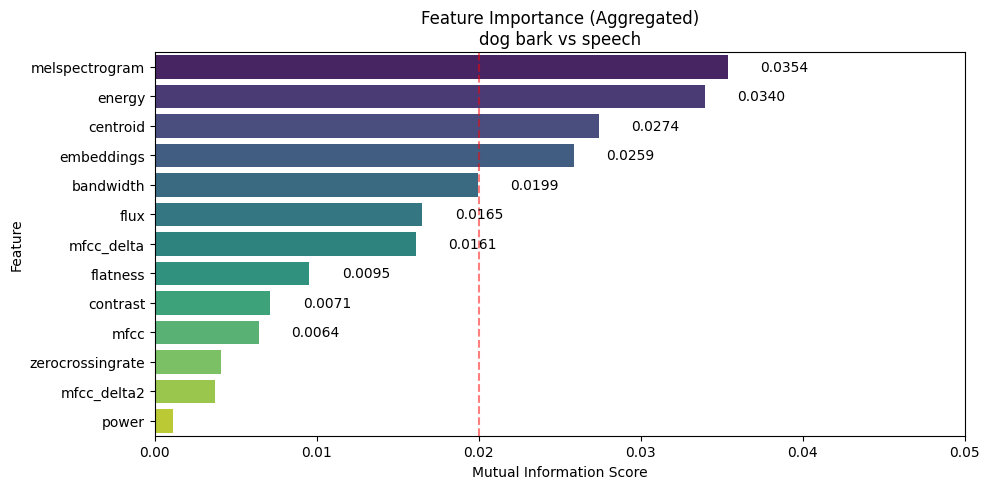


=== Top Aggregated Features ===
           Feature  MI_Score
1   melspectrogram  0.035394
10          energy  0.033971
6         centroid  0.027390
0       embeddings  0.025874
7        bandwidth  0.019948

Analyzing MFCC components...


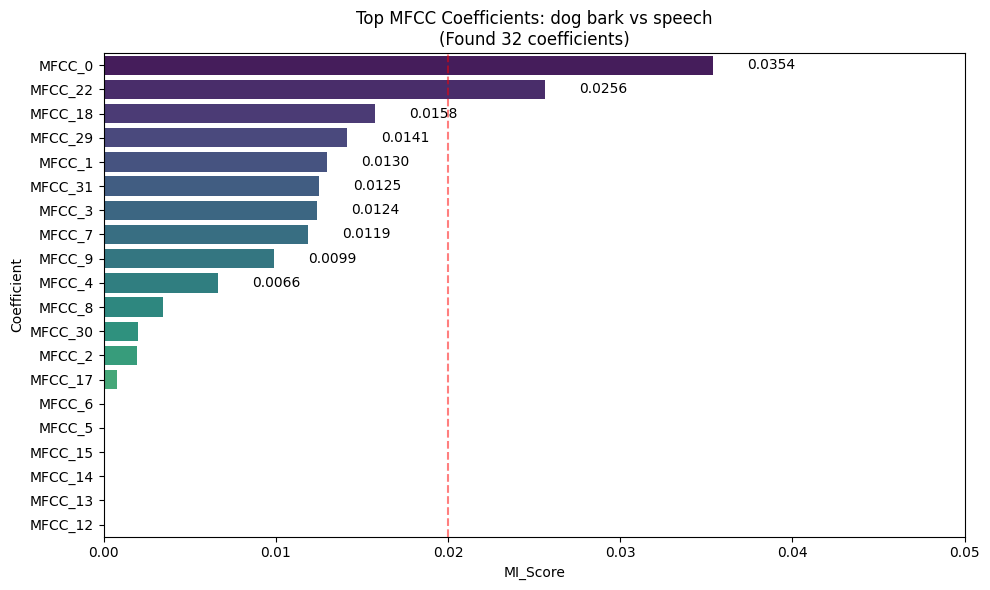


=== Top MFCC Components ===
   Coefficient  MI_Score
0       MFCC_0  0.035394
22     MFCC_22  0.025617
18     MFCC_18  0.015768
29     MFCC_29  0.014135
1       MFCC_1  0.012955


In [19]:
if __name__ == "__main__":
    # 1. Analyze aggregated features
    print("Analyzing aggregated features...")
    agg_results = analyze_feature_types("dog bark", "speech")
    print("\n=== Top Aggregated Features ===")
    print(agg_results.head())
    
    # 2. Analyze MFCC components
    print("\nAnalyzing MFCC components...")
    mfcc_results = analyze_mfcc_components("dog bark", "speech")
    print("\n=== Top MFCC Components ===")
    print(mfcc_results.head())

**Purpose:**
Identifies which features best distinguish between two sound classes using Mutual Information (MI). MI measures how much knowing a feature's value reduces uncertainty about the class.

**Key Insights:**

*1. MI Scores Interpretation:*

    Scores range 0-1 (higher = better class separation)

    - 0.5 → Excellent separator
    - 0.2-0.5 → Moderate utility
    - <0.2 → Weak predictor

*2. Visual Cues:*

- The barplot shows features ranked by discriminative power
- Red threshold line (at MI=0.5) highlights strongest features

**Conclusion:**
- Keep features above your MI threshold (>0.2)
- Re-evaluate features below threshold unless domain knowledge suggests importance

**FEATURE DISTRIBUTIONS FOR TOP FEATURES**

In [20]:
def find_best_features(mi_df, class1, class2, top_n=5, plot=True):
    """
    Recursively find and visualize features with best class separation.
    
    Args:
        mi_df: DataFrame containing feature importance scores
        class1, class2: Classes to compare
        top_n: Number of top features to return/plot
        plot: Whether to generate distribution plots
    Returns:
        DataFrame of features ranked by separation quality
    """
    from scipy.stats import gaussian_kde, entropy
    from sklearn.metrics import roc_auc_score
    
    # Merge data and filter features
    merged_df = an_df[an_df["labels"].isin([class1, class2])].merge(
        df_summary, 
        left_index=True, 
        right_index=True
    )
    
    # Available features (excluding metadata columns)
    available_features = [f for f in merged_df.columns 
                        if f not in ['labels', 'annotator', 'time', 'text', 
                                    'original_caption', 'filename', 'task_id']]
    
    # Pre-calculate separation metrics for all features
    results = []
    for feat in available_features:
        try:
            # Basic stats
            data = merged_df[[feat, 'labels']].dropna()
            class1_data = data[data['labels'] == class1][feat]
            class2_data = data[data['labels'] == class2][feat]
            
            if len(class1_data) < 2 or len(class2_data) < 2:
                continue
            
            # Effect size
            std = data[feat].std()
            effect_size = abs((class1_data.mean() - class2_data.mean()) / std)
            
            # KL divergence
            kde1 = gaussian_kde(class1_data)
            kde2 = gaussian_kde(class2_data)
            x = np.linspace(data[feat].min(), data[feat].max(), 100)
            p = kde1(x) + 1e-10
            q = kde2(x) + 1e-10
            kl_div = entropy(p, q) + entropy(q, p)
            
            # AUC-ROC
            y_true = np.where(data['labels'] == class1, 1, 0)
            auc = roc_auc_score(y_true, data[feat])
            auc_separation = max(auc, 1-auc)  # Account for inverse relationships
            
            # Combined score (weighted)
            combined_score = (effect_size * 0.4 + kl_div * 0.3 + auc_separation * 0.3)
            
            results.append({
                'feature': feat,
                'effect_size': effect_size,
                'kl_divergence': kl_div,
                'auc_roc': auc_separation,
                'combined_score': combined_score,
                'class1_mean': class1_data.mean(),
                'class2_mean': class2_data.mean()
            })
        except:
            continue
    
    # Create ranked DataFrame
    metrics_df = pd.DataFrame(results).sort_values('combined_score', ascending=False)
    
    if plot:
        # Plot top features
        plot_features = metrics_df.head(top_n)['feature'].tolist()
        plt.figure(figsize=(4*top_n, 4))
        
        for i, feat in enumerate(plot_features, 1):
            plt.subplot(1, top_n, i)
            
            # Get metrics for title
            feat_metrics = metrics_df[metrics_df['feature'] == feat].iloc[0]
            
            # Plot distributions
            for cls, color in zip([class1, class2], sns.color_palette("Set2", 2)):
                data = merged_df[merged_df['labels'] == cls][feat].dropna()
                sns.kdeplot(data, label=cls, fill=True, alpha=0.5, color=color)
                plt.axvline(data.mean(), linestyle='--', color=color)
            
            plt.title(f"{feat}\n"
                     f"Δμ/σ={feat_metrics['effect_size']:.2f} | "
                     f"KL={feat_metrics['kl_divergence']:.2f}\n"
                     f"AUC={feat_metrics['auc_roc']:.2f}")
            plt.legend()
        
        plt.suptitle(f"Top {top_n} Separating Features: {class1} vs {class2}", y=1.05)
        plt.tight_layout()
        plt.show()
    
    return metrics_df

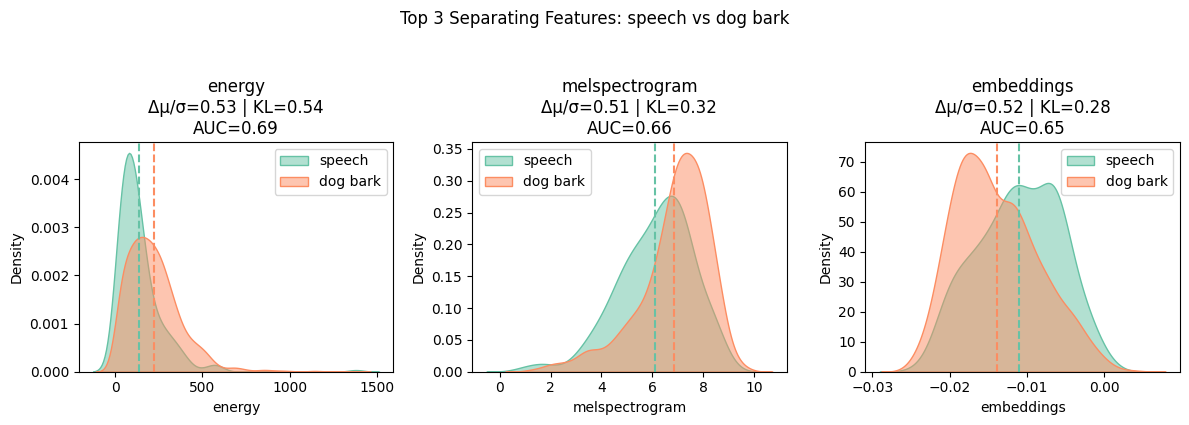

In [21]:
mi_df = analyze_feature_types('speech', 'dog bark', show_plot=False)
best_features = find_best_features(mi_df, 'speech', 'dog bark', top_n=3)

In [30]:
# Show the ranked metrics
print(best_features[['feature', 'combined_score', 'effect_size', 'kl_divergence', 'auc_roc']].head())

           feature  combined_score  effect_size  kl_divergence   auc_roc
12          energy        0.579107     0.529136       0.535253  0.689589
3   melspectrogram        0.499162     0.511920       0.319987  0.661325
2       embeddings        0.485573     0.516475       0.279277  0.650665
4             mfcc        0.478336     0.486756       0.290536  0.654907
10            flux        0.383474     0.341847       0.206672  0.615778


**Purpose:**
Visualizes how feature distributions differ between classes to complement MI scores.

**Key Insights:**

*1. Distribution Shapes:*

- Well-separated peaks → Feature is discriminative
- Overlapping curves → Feature is less useful

*2. Effect Size (Δμ):*

- The annotated mean difference quantifies separation magnitude
- Rule of thumb: Δμ > 1 standard deviation → Strong effect

We prioritize features with:
- High MI scores AND
- Cleanly separated distributions:
    
    Investigate further when:
    - High MI but overlapping distributions (possible outliers)
    - Low MI but clean separation (check feature scaling)

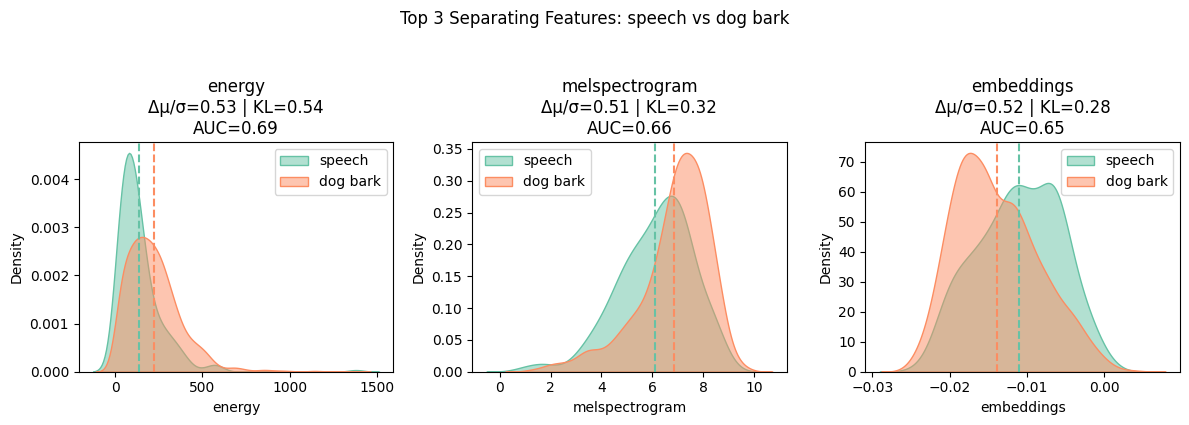


=== Top Discriminative Features ===
           feature  combined_score  effect_size  kl_divergence   auc_roc
12          energy        0.579107     0.529136       0.535253  0.689589
3   melspectrogram        0.499162     0.511920       0.319987  0.661325
2       embeddings        0.485573     0.516475       0.279277  0.650665


In [29]:
def analyze_and_plot_best_features(class1, class2, top_n=5):
    """
    Complete analysis pipeline that:
    1. Calculates feature importance (MI scores)
    2. Identifies best-separating features
    3. Plots both rankings and distributions
    """
    # 1. Get Mutual Information scores
    mi_df = analyze_feature_types(class1, class2, show_plot=False)
    
    # 2. Find best features with combined metrics
    best_features_df = find_best_features(mi_df, class1, class2, top_n=top_n)
    
    # 3. Print quantitative results
    print("\n=== Top Discriminative Features ===")
    print(best_features_df[['feature', 'combined_score', 'effect_size', 
                          'kl_divergence', 'auc_roc']].head(top_n))
    
    return best_features_df

# Run the complete analysis
best_features = analyze_and_plot_best_features('speech', 'dog bark', top_n=3)

#### (c) How well do the chosen audio features group according to the discretized class labels? 

*(Linked to 1a's label accuracy and 1b's feature importance)*

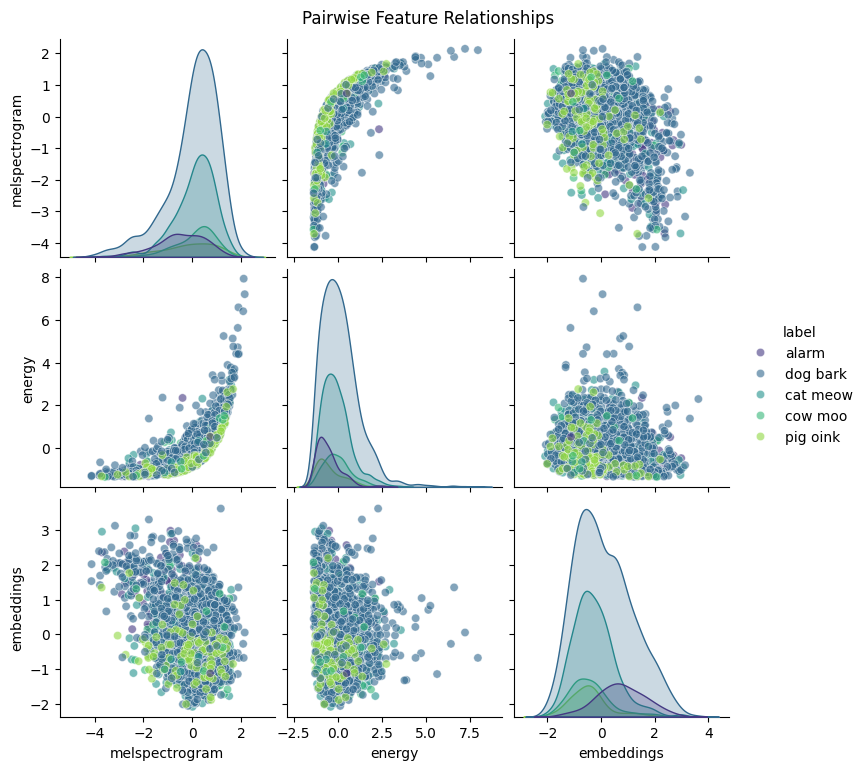

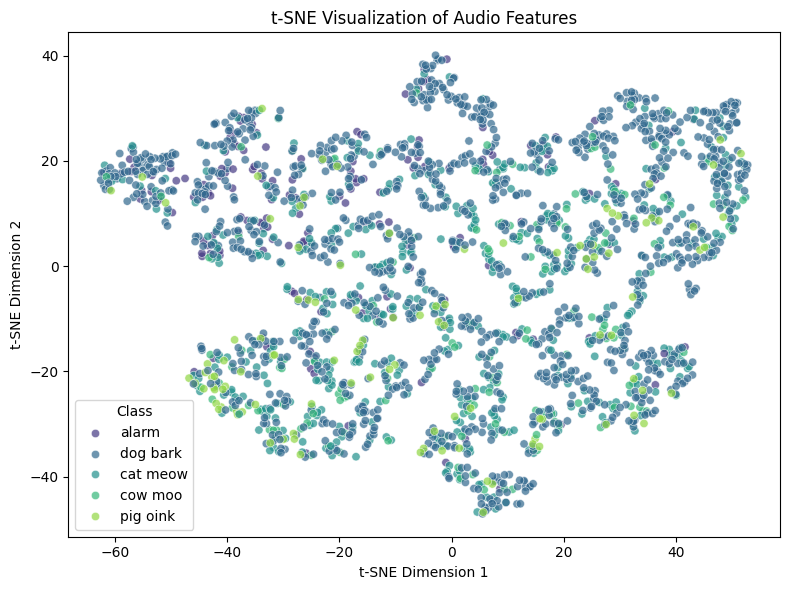

In [31]:
# Select top 5 classes and top 3 features based on previous analysis
top_classes = ['cat meow', 'dog bark', 'cow moo', 'alarm', 'pig oink']
top_features = ['melspectrogram', 'energy', 'embeddings']

common_idx = meta_df.index.intersection(an_df.index)
meta_top = meta_df.loc[common_idx]
an_top = an_df.loc[common_idx]

# Filter for top classes
mask = an_top['labels'].isin(top_classes)
meta_top = meta_top.loc[mask]
an_top = an_top.loc[mask]

# Now build features and labels from the same filtered samples:
X = []
for idx in meta_top.index:
    file_name = meta_top.loc[idx, 'filename'].replace('.mp3', '.npz')
    data = np.load(os.path.join(AUDIO_FEATURE_FOLDER, file_name))
    sample_features = [np.mean(data[feat]) for feat in top_features]
    X.append(sample_features)
X = np.array(X)
y = an_top['labels'].values  # now length matches X

# Now scale and plot
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Existing pairplot
sns.pairplot(pd.DataFrame(X_scaled, columns=top_features).assign(label=y),
             hue='label', palette='viridis', plot_kws={'alpha': 0.6})
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', alpha=0.7)
plt.title("t-SNE Visualization of Audio Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Class')
plt.tight_layout()
plt.show()

#### Do samples of the same class form tight clusters?

*(Quantifies the visual intuition from the cell above)*

In [32]:
from sklearn.metrics import silhouette_score
# Evaluate cluster quality
try:
    silhouette_tsne = silhouette_score(X_tsne, y)
    print(f"Silhouette Score (t-SNE): {silhouette_tsne:.3f}")
except ValueError as e:
    print(f"Could not compute silhouette score: {e}")

Silhouette Score (t-SNE): -0.119
